<a href="https://colab.research.google.com/github/muhammadnouman911/Audio-Classification/blob/main/Classification_(ESC_50).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ESC-50 Audio Classification Full Pipeline with Preprocessing Visualization

 ============================================
# STEP 1: INSTALL REQUIRED LIBRARIES
 ============================================

In [ ]:
!pip install librosa matplotlib pandas scikit-learn tensorflow --quiet


 ============================================
# STEP 2: IMPORT LIBRARIES
 ============================================

In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive
import IPython.display as ipd

 ============================================
# STEP 3: MOUNT GOOGLE DRIVE
 ============================================

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 ============================================
# STEP 4: SET PATHS
 ============================================

In [ ]:
DATA_PATH = '/content/drive/MyDrive/Datasets/ESC-50-master/'
AUDIO_PATH = DATA_PATH + 'audio/'
META_PATH = DATA_PATH + 'meta/esc50.csv'

 ============================================
# STEP 5: LOAD METADATA
 ============================================

In [ ]:
metadata = pd.read_csv(META_PATH)
display(metadata.head())

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


 ============================================
# STEP 6: AUDIO PREPROCESSING VISUALIZATION
 ============================================
# Pick a sample file

In [ ]:
sample_file = os.path.join(AUDIO_PATH, metadata.iloc[0]['filename'])
y, sr = librosa.load(sample_file, sr=22050)

# 1. Listen to audio

In [ ]:
ipd.Audio(sample_file)

# 2. Plot waveform

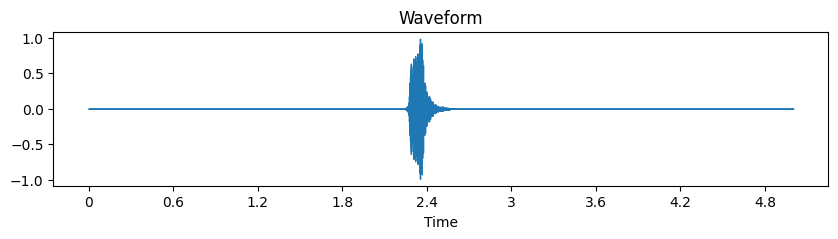

In [ ]:
plt.figure(figsize=(10, 2))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform")
plt.show()

# 3. Plot Mel-Spectrogram

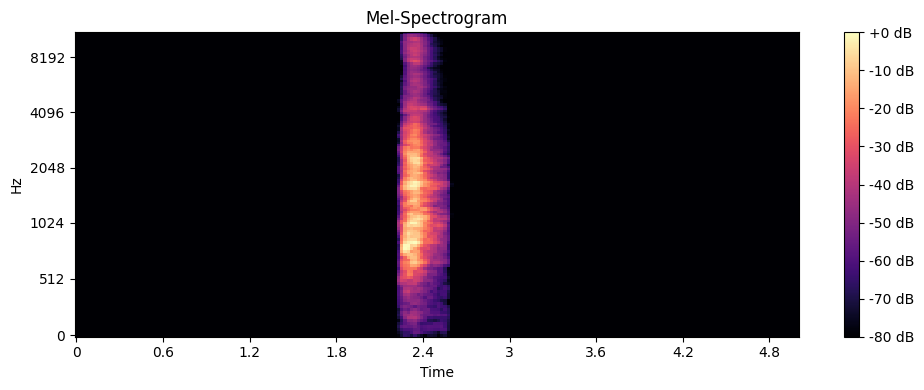

In [ ]:
mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
mel_db = librosa.power_to_db(mel, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel')
plt.title('Mel-Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

 ============================================
# STEP 7: EXTRACT FEATURES FROM ALL FILES
 ============================================

In [ ]:
def extract_features(file_path, max_len=5):
    y, sr = librosa.load(file_path, sr=22050)
    if len(y) > sr * max_len:
        y = y[:sr * max_len]
    else:
        y = np.pad(y, (0, sr * max_len - len(y)))

    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_db = librosa.power_to_db(mel_spec, ref=np.max)
    mel_db = (mel_db - np.mean(mel_db)) / np.std(mel_db)  # normalize

    return mel_db

X = []
y = []

for i, row in metadata.iterrows():
    file_path = os.path.join(AUDIO_PATH, row['filename'])
    label = row['category']
    features = extract_features(file_path)
    X.append(features)
    y.append(label)

X = np.array(X)
X = X[..., np.newaxis]

# Encode labels

In [ ]:
y_encoded = LabelEncoder().fit_transform(y)
y_cat = to_categorical(y_encoded)


# Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y_cat)


 ============================================
# STEP 8: BUILD CNN MODEL
 ============================================

In [ ]:
model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(128, X.shape[2], 1)),
    MaxPooling2D((2,2)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(50, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 214, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 107, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 105, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 52, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 49920)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,194,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         3,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,202,994 (12.22 MB)

 Trainable params: 3,202,994 (12.22 MB)

 Non-trainable params: 0 (0.00 B)

 ============================================
# STEP 9: TRAIN MODEL
 ============================================

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=1000, validation_data=(X_test, y_test), batch_size=32, callbacks=[early_stop])

Epoch 1/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.0248 - loss: 4.2317 - val_accuracy: 0.0225 - val_loss: 3.8641
Epoch 2/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.0411 - loss: 3.8012 - val_accuracy: 0.0750 - val_loss: 3.6805
Epoch 3/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0734 - loss: 3.5819 - val_accuracy: 0.1475 - val_loss: 3.3810
Epoch 4/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1906 - loss: 3.1076 - val_accuracy: 0.2225 - val_loss: 3.0342
Epoch 5/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2344 - loss: 2.7416 - val_accuracy: 0.2775 - val_loss: 2.7890
Epoch 6/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3368 - loss: 2.3639 - val_accuracy: 0.2975 - val_loss: 2.5677
Epoch 7/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4391 - loss: 1.9124 - val_accuracy: 0.3175 - val_loss: 2.4652
Epoch 8/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4776 - loss: 1.7588 - val_accu

 ============================================
# STEP 10: EVALUATE & PLOT RESULTS
 ============================================

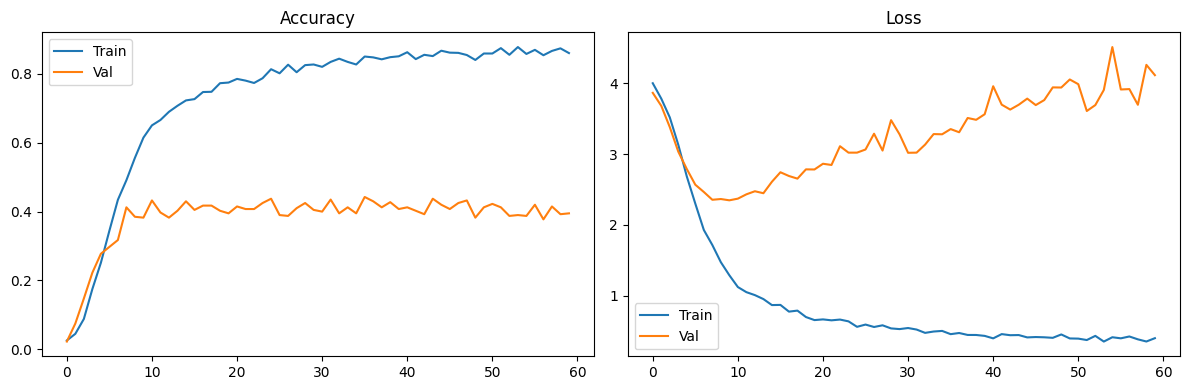

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate final accuracy

In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Final Test Accuracy: {acc*100:.2f}%")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3827 - loss: 2.3350
Final Test Accuracy: 38.25%


 ============================================
# STEP 11: PREDICT ON CUSTOM FILE
 ============================================

In [ ]:
# Your file path
custom_audio_path = "/content/drive/MyDrive/5-237499-A-4.wav"

# Predict function (make sure extract_features and model are already defined)
def predict_file(file_path):
    features = extract_features(file_path)
    features = features[np.newaxis, ..., np.newaxis]  # Add batch and channel dimensions
    prediction = model.predict(features)
    class_index = np.argmax(prediction)
    class_name = LabelEncoder().fit(y).classes_[class_index]

    # Optional: print top 5 class predictions
    top_5_idx = prediction[0].argsort()[-5:][::-1]
    print("Top 5 predictions:")
    for i in top_5_idx:
        print(f"{LabelEncoder().fit(y).classes_[i]}: {prediction[0][i]*100:.2f}%")

    return class_name

# Run prediction
predicted_class = predict_file(custom_audio_path)
print("\n🎯 Predicted class for your file:", predicted_class)

# Optional: listen to the file
import IPython.display as ipd
ipd.Audio(custom_audio_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Top 5 predictions:
frog: 65.37%
sheep: 4.36%
sea_waves: 3.80%
snoring: 3.05%
dog: 2.96%

🎯 Predicted class for your file: frog
